In [1]:
import SimpleITK as sitk
import os
import numpy as np
import torch
import torch.nn.functional as F
import nibabel as nib
import matplotlib.pyplot as plt
import scipy.io
from torchmetrics.functional import dice


-preprocessing steps:
1. Resample each original .nii.gz volume to a same size of 111.
2. Add a 16-pixel margin around the heart boundary to keep the heart well centered in the field of view.
3. Scale intensities.
4. Finally, resample the volume to 144 × 144 × 128.
5. Perform initial affine alignment of the heart using Elastix.


In [ ]:
# Load each cardiac image and print the information (spacing, size, intensity range, origin, direction)
add = '/path/to/XMorpher-registration/Prepare-Data/0_raw_data/fixed/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints": 
        data_add = add+im
        img = sitk.ReadImage(data_add)
        image= nib.load(data_add).get_fdata()
        print(im, img.GetSpacing(),img.GetSize(),(image.min(),image.max()), img.GetOrigin(), img.GetDirection())
        i+=1
print(i)

ct_train_1004_image.nii.gz (0.3203119933605194, 0.3203119933605194, 0.625) (512, 512, 200) (-3022.0, 1398.0) (-52.0, 95.17942810058594, -195.875) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
1


In [ ]:
# Load each cardiac image and print information (spacing, size, intensity range, origin, direction)
add = '/path/to/XMorpher-registration/Prepare-Data/0_raw_data/labelF/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints": 
        data_add = add+im
        img = sitk.ReadImage(data_add)
        # img_ar = sitk.GetArrayFromImage(img)
        image= nib.load(data_add).get_fdata()
        # img_ar = np.transpose(img_ar, (0,1,2))
        # img = sitk.GetImageFromArray(img_ar)
        print(im, img.GetSpacing(),img.GetSize(),(image.min(),image.max()), img.GetOrigin(), img.GetDirection())
        i+=1
print(i)

ct_train_1004_label.nii.gz (0.3203119933605194, 0.3203119933605194, 0.625) (512, 512, 200) (0.0, 850.0) (-52.0, 95.17942810058594, -195.875) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
1


In [3]:
# Resample images and labels
def resample_sitk_image(sitk_image, size=None, interpolator=None,
                        fill_value=0, is_label=False):
    """Resamples an ITK image to a new grid. 
    Parameters
    ----------
    sitk_image : SimpleITK image or path str : 
    size : tuple or int : Tuple of integers for each dimension, or single int for uniform size
    interpolator : str : Either `nearest`, `linear` or None.
    fill_value : int
    is_label : bool : If True, forces nearest neighbor interpolation to preserve discrete labels
    -------
    Returns SimpleITK image.
    """
    
    _SITK_INTERPOLATOR_DICT = {
        'nearest': sitk.sitkNearestNeighbor,
        'linear': sitk.sitkLinear,
        'gaussian': sitk.sitkGaussian,
        'label_gaussian': sitk.sitkLabelGaussian,
        'bspline': sitk.sitkBSpline,
        'hamming_sinc': sitk.sitkHammingWindowedSinc,
        'cosine_windowed_sinc': sitk.sitkCosineWindowedSinc,
        'welch_windowed_sinc': sitk.sitkWelchWindowedSinc,
        'lanczos_windowed_sinc': sitk.sitkLanczosWindowedSinc
    }
    if isinstance(sitk_image, str):
        sitk_image = sitk.ReadImage(sitk_image)
    num_dim = sitk_image.GetDimension()
    
    if not interpolator:
        # Force nearest neighbor for label images
        if is_label:
            interpolator = 'nearest'
        else:
            # Binary input (e.g., masks) are resampled with nearest neighbors, otherwise linear interpolation
            interpolator = 'linear'
            pixelid = sitk_image.GetPixelIDValue()
            if pixelid == 1:  # 8-bit unsigned int
                interpolator = 'nearest'
    
    # Override interpolator if is_label is True (safety check)
    if is_label and interpolator != 'nearest':
        print(f"Warning: Overriding interpolator '{interpolator}' to 'nearest' for label image")
        interpolator = 'nearest'
    
    orig_pixelid = sitk_image.GetPixelIDValue()
    orig_origin = sitk_image.GetOrigin()
    orig_direction = sitk_image.GetDirection()
    orig_spacing = np.array(sitk_image.GetSpacing())
    orig_size = np.array(sitk_image.GetSize(), dtype=int)
    
    if not size:
        # If no size is given, resample isotropically to the smallest spacing
        min_spacing = orig_spacing.min()
        new_spacing = [min_spacing]*num_dim
        new_size = orig_size*(orig_spacing/new_spacing)
        new_size = np.ceil(new_size).astype(int)
    else:
        # Convert size to list if it's a single integer (uniform size)
        if isinstance(size, int):
            new_size = [size] * num_dim
        else:
            new_size = [int(s) for s in size]
        
        # Calculate the required spacing to achieve the desired size
        new_spacing = orig_spacing * (orig_size / np.array(new_size))
        new_spacing = new_spacing.tolist()
    
    new_size = [int(s) for s in new_size]  # SimpleITK expects lists, not ndarrays
    
    assert interpolator in _SITK_INTERPOLATOR_DICT.keys(),\
        f'`interpolator` should be one of {_SITK_INTERPOLATOR_DICT.keys()}'
    sitk_interpolator = _SITK_INTERPOLATOR_DICT[interpolator]
    
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetOutputSpacing(new_spacing)
    resample_filter.SetSize(new_size)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetOutputOrigin(orig_origin)
    resample_filter.SetInterpolator(sitk_interpolator)
    resample_filter.SetOutputPixelType(orig_pixelid)
    resample_filter.SetDefaultPixelValue(fill_value)
    resampled_sitk_image = resample_filter.Execute(sitk_image)
    
    return resampled_sitk_image

In [ ]:
#resample to 111,111,111. 
target_size = (111, 111, 111)

add = '/path/to/XMorpher-registration/Prepare-Data/0_raw_data/labelF/'
add1 = '/path/to/XMorpher-registration/Prepare-Data/1_resampled_111/fixed/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints":
        new_add = add+im
        add_data = add1+im
        #add_data = add1+f'{i}.nii.gz'
        
        itk_image = sitk.ReadImage(new_add)
        #resampled_sitk_img = resample_sitk_image(itk_image, size=target_size, is_label=False, fill_value=0) #for CT images (fixed and moving)

        resampled_sitk_img = resample_sitk_image(itk_image, size=target_size, is_label=True, fill_value=0) #for labels
        
        

        print(im)
        sitk.WriteImage(resampled_sitk_img, add_data)
        i+=1

1004.nii.gz


In [ ]:
# Load each cardiac image and print information (spacing, size, intensity range, origin, direction)
add = '/path/to/XMorpher-registration/Prepare-Data/1_resampled_111/fixed/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints": 
        data_add = add+im
        img = sitk.ReadImage(data_add)
        image= nib.load(data_add).get_fdata()
        print(im, img.GetSpacing(),img.GetSize(),(image.min(),image.max()), img.GetOrigin(), img.GetDirection())
        i+=1
print(i)

ct_train_1004_image.nii.gz (1.4774751663208008, 1.4774751663208008, 1.1261261701583862) (111, 111, 111) (-3022.0, 1326.9940185546875) (-52.0, 95.17942810058594, -195.875) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
1


In [ ]:
add = '/path/to/XMorpher-registration/Prepare-Data/1_resampled_111/labelF/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints": 
        data_add = add+im
        img = sitk.ReadImage(data_add)
        image= nib.load(data_add).get_fdata()
        print(im, img.GetSpacing(),img.GetSize(),(image.min(),image.max()), img.GetOrigin(), img.GetDirection())
        i+=1
print(i)

ct_train_1004_label.nii.gz (1.4774751663208008, 1.4774751663208008, 1.1261261701583862) (111, 111, 111) (0.0, 850.0) (-52.0, 95.17942810058594, -195.875) (1.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0)
1


(111, 111, 111)
(81, 71, 107)
0.0 850.0


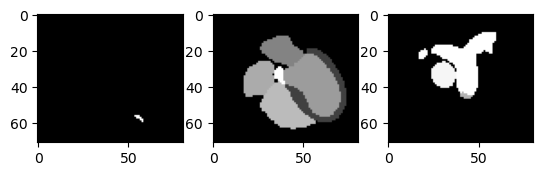

In [ ]:
#crop and show
ct = nib.load('/path/to/XMorpher-registration/Prepare-Data/1_resampled_111/labelM/ct_train_1012_label.nii.gz').get_fdata()
print(ct.shape)
ct = ct[10:-20,22:-18,4:] 

print(ct.shape)

#c = rotate(ct, 180, reshape=False)
#ct = np.flipud(ct)
plt.subplot(1, 3, 1)
plt.imshow(ct[:,:,0].T, cmap='gray') #first slice

plt.subplot(1, 3, 2)
plt.imshow(ct[:,:,53].T, cmap='gray') #middle slice

plt.subplot(1, 3, 3)
plt.imshow(ct[:,:,99].T, cmap='gray') # last slice

print(ct.min(),ct.max())

In [ ]:
#save the cropped image
ct = nib.Nifti1Image(ct, affine=None) 
nib.save(ct,'/path/to/XMorpher-registration/Prepare-Data/2_cropped/labelM/1012.nii.gz')

In [ ]:
#set unique labels from 1 to 7 for labels

add= "/path/to/XMorpher-registration/Prepare-Data/2_cropped/labelF/"
save = '/path/to/XMorpher-registration/Prepare-Data/3_intensity_scaled/labelF/'
for ct in os.listdir(add):
    if ct!='.ipynb_checkpoints': 
        new_add = add+ct
        save_add = save+ct
        lab = nib.load(new_add).get_fdata()

        print(np.unique(lab))

        lab = np.where(lab == 205, 1, lab)
        lab = np.where(lab == 420, 2, lab)
        lab = np.where(lab == 500, 3, lab)
        lab = np.where(lab == 550, 4, lab)
        lab = np.where(lab == 600, 5, lab)
        lab = np.where(lab == 820, 6, lab)
        lab = np.where(lab == 850, 7, lab)

        lab = np.transpose(lab, (2,1,0))

        print(np.unique(lab))

        img=sitk.GetImageFromArray(lab)

        # img_ar = sitk.GetArrayFromImage(img)
        # img_ar = np.transpose(img_ar, (0,1,2))
        # img = sitk.GetImageFromArray(img_ar)
        
        sitk.WriteImage(img,save_add)

[  0. 205. 420. 500. 550. 600. 820. 850.]
[0. 1. 2. 3. 4. 5. 6. 7.]


In [ ]:
#Normalization within the mask region
def get_binary_mask(image):
    if isinstance(image,np.ndarray):
        image=sitk.GetImageFromArray(image)
    
        
    otsu_filter = sitk.OtsuThresholdImageFilter()
    otsu_filter.SetInsideValue(0)
    otsu_filter.SetOutsideValue(1)
    seg = otsu_filter.Execute(image)
    
    hole_filler=sitk.BinaryMorphologicalOpeningImageFilter()
    seg=hole_filler.Execute(seg)

    # seg = sitk.BinaryErode(seg)
    return seg


def normalize_intensities(volume, mask):
    '''
    Normalizes the intensities within the volume based on the mean and std of the values in the mask
    '''
    volume_array = sitk.GetArrayFromImage(volume)
    mask_array = sitk.GetArrayFromImage(mask)
    mean = volume_array[mask_array.astype(bool)].mean(axis=-1) 
    std = volume_array[mask_array.astype(bool)].std(axis=-1)

    return sitk.Cast((volume-mean)/std, sitk.sitkFloat32)

In [ ]:
#normalize ct images based on the mean and sdt of the masked region
add= "/path/to/XMorpher-registration/Prepare-Data/2_cropped/fixed/"
save = "/path/to/XMorpher-registration/Prepare-Data/3_intensity_scaled/fixed/"
for ct in os.listdir(add):
    if ct!='.ipynb_checkpoints': 
        
        new_add = add+ct
        save_add = save+ct
        nii = nib.load(new_add)
        ct_sitk = sitk.ReadImage(new_add)
        
        mask = get_binary_mask(ct_sitk)
        ct_normalized = normalize_intensities(ct_sitk, mask)
        ct_normalized = sitk.GetArrayFromImage(ct_normalized)
        ct_normalized = np.transpose(ct_normalized, (2,1,0))

        ct = nib.Nifti1Image(ct_normalized, affine=nii.affine, header=nii.header)

        
        nib.save(ct,save_add)
        

In [ ]:
#resample to 144, 144, 128. 
target_size = (144, 144, 128)

add = '/path/to/XMorpher-registration/Prepare-Data/3_intensity_scaled/labelM/'
add1 = '/path/to/XMorpher-registration/Prepare-Data/4_resampled_128/labelM/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints":
        new_add = add+im
        add_data = add1+im
        #add_data = add1+f'{i}.nii.gz'
        
        itk_image = sitk.ReadImage(new_add)

        #resampled_sitk_img = resample_sitk_image(itk_image, size=target_size, is_label=False, fill_value=0)
        resampled_sitk_img = resample_sitk_image(itk_image, size=target_size, is_label=True, fill_value=0) #for labels


        sitk_arr = sitk.GetArrayFromImage(resampled_sitk_img)
        arr = np.transpose(sitk_arr, (0,1,2))
        resampled_sitk_img = sitk.GetImageFromArray(arr)
        print(im)
        sitk.WriteImage(resampled_sitk_img, add_data)
        i+=1

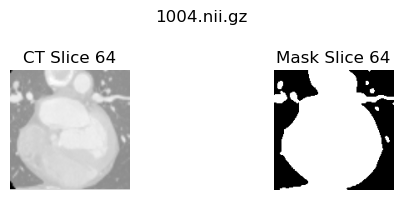

In [ ]:
# visualize a CT and its mask
add= "/path/to/XMorpher-registration/Prepare-Data/4_resampled_128/fixed/"
for ct in os.listdir(add):
    if ct!='.ipynb_checkpoints': 
        
        new_add = add+ct
        nii = nib.load(new_add)
        ct_sitk = sitk.ReadImage(new_add)
        
        mask = get_binary_mask(ct_sitk)
        ct_normalized = normalize_intensities(ct_sitk, mask)
        ct_normalized = sitk.GetArrayFromImage(ct_normalized)
        
        # Visualize middle slice
        mid_slice = ct_normalized.shape[0] // 2
        mask_array = sitk.GetArrayFromImage(mask)
        
        fig, axes = plt.subplots(1, 2, figsize=(6, 2))
        axes[0].imshow(ct_normalized[mid_slice], cmap='gray')
        axes[0].set_title(f'CT Slice {mid_slice}')
        axes[0].axis('off')
        
        axes[1].imshow(mask_array[mid_slice], cmap='gray')
        axes[1].set_title(f'Mask Slice {mid_slice}')
        axes[1].axis('off')
        
        plt.suptitle(f'{ct}')
        plt.tight_layout()
        plt.show()

In [ ]:
add = '/path/to/XMorpher-registration/Prepare-Data/4_resampled_128/fixed/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints": 
        data_add = add+im
        img = sitk.ReadImage(data_add)
        image= nib.load(data_add).get_fdata()
        print(im, img.GetSpacing(),img.GetSize(),(image.min(),image.max()), img.GetOrigin(), img.GetDirection())
        i+=1
print(i)

1004.nii.gz (1.0, 1.0, 1.0) (144, 144, 128) (-14.666206359863281, 3.6009562272164564) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
1


In [ ]:
add = '/path/to/XMorpher-registration/Prepare-Data/4_resampled_128/labelF/'
i=0
for im in sorted(os.listdir(add)):
    if im!=".ipynb_checkpoints": 
        data_add = add+im
        img = sitk.ReadImage(data_add)
        image= nib.load(data_add).get_fdata()
        print(im, img.GetSpacing(),img.GetSize(),(image.min(),image.max()), img.GetOrigin(), img.GetDirection())
        i+=1
print(i)

1004.nii.gz (1.0, 1.0, 1.0) (144, 144, 128) (0.0, 7.0) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
1


-forming registration pairs
1. 15 labeled images form 210 labeled-labeled pairs for the test.
2. 5 labeled images combined with 100 unlabeled images generate 500 labeled–unlabeled pairs.
3. 100 unlabeled images form 9900 unlabeled-labeled pairs


Run the following to form training/testing pairs:

Unlabeled–unlabeled and Unlabeled–labeled: Affine_Elastix4train.py

Test: Affine_Elastix4test.py


1004.nii.gz (1.0, 1.0, 1.0) (144, 144, 128) (-14.666206359863281, 3.6009562272164564) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
1012.nii.gz (1.0, 1.0, 1.0) (144, 144, 128) (-19.16656494140625, 4.986966883142788) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
moved_image (1.0, 1.0, 1.0) (128, 144, 144) (-6.72702, 3.863791) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


Text(0.5, 1.0, 'Moved(affine)')

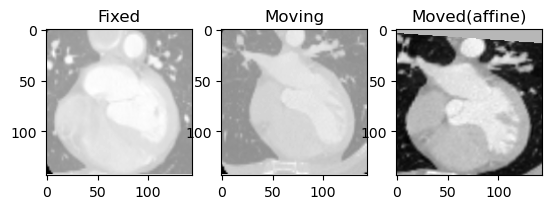

In [ ]:
#Display the results for affine registration: fixed image, moving image, and moved image.

add1 = "/path/to/XMorpher-registration/Prepare-Data/4_resampled_128/fixed/1004.nii.gz"
add2 = "/path/to/XMorpher-registration/Prepare-Data/4_resampled_128/moving/1012.nii.gz"
add3 = "/path/to/XMorpher-registration/data/test/1004_1012.mat"
ct1 = nib.load(add1).get_fdata()
ct2 = nib.load(add2).get_fdata()
ct3 = scipy.io.loadmat(add3)
mov_im = ct3['mov_img']
image_moved = sitk.GetImageFromArray(mov_im)

fix_im = ct3['fix_img']
# fix_lab = ct3['fix_lab']
# mov_lab = ct3['mov_lab']

# Print information for each image
for add in [add1, add2]:
    img = sitk.ReadImage(add)
    image = nib.load(add).get_fdata()
    print(add.split('/')[-1], img.GetSpacing(), img.GetSize(), (image.min(), image.max()), img.GetOrigin(), img.GetDirection())

# Print info for moved image
print('moved_image', image_moved.GetSpacing(), image_moved.GetSize(), (mov_im.min(), mov_im.max()), image_moved.GetOrigin(), image_moved.GetDirection())

# ct1_flipped = np.flip(ct1, axis=1)
# ct2_flipped = np.flip(ct2, axis=1)

plt.subplot(1,3,1)
plt.imshow(ct1[:,:,60].T, cmap="gray")
plt.title('Fixed')


plt.subplot(1,3,2)
plt.imshow(ct2[:,:,60].T, cmap="gray")
plt.title('Moving')


plt.subplot(1,3,3)
plt.imshow(mov_im[:,:,60].T, cmap="gray")
plt.title('Moved(affine)')

dict_keys(['__header__', '__version__', '__globals__', 'fix_img', 'mov_img', 'fix_lab', 'mov_lab'])
(144, 144, 128)
(144, 144, 128)
(144, 144, 128)
(144, 144, 128)
-14.666206359863281 3.6009562272164564
-6.72702 3.863791
0.0 7.0
0.0 7.0


Text(0.5, 1.0, 'mov_lab')

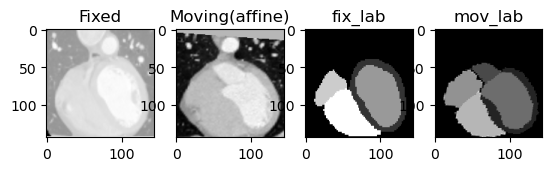

In [ ]:
# read a .mat file and display a slice of it.

add1 = '/path/to/XMorpher-registration/data/test/1004_1012.mat'
mat_data1 = scipy.io.loadmat(add1)
print(mat_data1.keys())
mov_im = mat_data1['mov_img']
fix_im = mat_data1['fix_img']
fix_lab = mat_data1['fix_lab']
mov_lab = mat_data1['mov_lab']

print(fix_im.shape)
print(mov_im.shape)
print(fix_lab.shape)
print(mov_lab.shape)

print(fix_im.min(), fix_im.max())
print(mov_im.min(), mov_im.max())
print(fix_lab.min(), fix_lab.max())
print(mov_lab.min(), mov_lab.max())

plt.subplot(1,4,1)
plt.imshow(fix_im[:,:,40].T, cmap="gray")
plt.title('Fixed')


plt.subplot(1,4,2)
plt.imshow(mov_im[:,:,40].T, cmap="gray")
plt.title('Moving(affine)')

plt.subplot(1,4,3)
plt.imshow(fix_lab[:,:,40].T, cmap="gray")
plt.title('fix_lab')

plt.subplot(1,4,4)
plt.imshow(mov_lab[:,:,40].T, cmap="gray")
plt.title('mov_lab')


Training Commands:

To train the unsupervised XMorpher (vm-xmorpher), run: python Unsuptrain.py

To train the semi-supervised XMorpher (pc-xmorpher), run: python Semi_train.py

In [ ]:
# compute dice score result from XMorpher

add1 = '/path/to/XMorpher-registration/out/Semi/nifti_out/w_label_m_to_f/'
add2 = '/path/to/XMorpher-registration/data/test/'
dice_scores = []

for im in sorted(os.listdir(add1)):
    if im.endswith('.nii.gz'):
        add_moved = add1+im
        movedlabel = sitk.ReadImage(add_moved)
        img = im.split('.')[0]

        add_fixd = add2 + img + ".mat"
        mat_data = scipy.io.loadmat(add_fixd)
        fixed_lab = mat_data['fix_lab']
        
        movedlabel = sitk.GetArrayFromImage(movedlabel).transpose(2,1,0)
        

        movedlabeltr_tensor = torch.Tensor(movedlabel).type(torch.int64)
        fixedlabel_tensor = torch.Tensor(fixed_lab).type(torch.int64)


        Dicescore = dice(preds=movedlabeltr_tensor, target=fixedlabel_tensor, ignore_index=0)
        print(Dicescore)
        dice_scores.append(Dicescore)
        print("Dice scores for each label:", dice_scores)
        print("Average Dice score:", np.mean(dice_scores))


In [ ]:

# Display one rusult from XMorpher
add1 = '/path/to/XMorpher-registration/out/Semi/nifti_out/w_m_to_f/8_7.nii.gz'
add2 = "/path/to/XMorpher-registration/out/Semi/nifti_out/w_label_m_to_f/8_7.nii.gz"
add3 = "//path/to/XMorpher-registration/data/test/8_7.mat"
moved_ct = nib.load(add1).get_fdata()
moved_label = nib.load(add2).get_fdata()
ct3 = scipy.io.loadmat(add3)
mov_im = ct3['mov_img']
fix_im = ct3['fix_img']
slice_no = 40
plt.subplot(1,3,1)
plt.imshow(fix_im[:,:,slice_no].T, cmap="gray")
plt.title('Fixed')


plt.subplot(1,3,2)
plt.imshow(mov_im[:,:,slice_no].T, cmap="gray")
plt.title('Moving')


plt.subplot(1,3,3)
plt.imshow(moved_ct[:,:,slice_no].T, cmap="gray")
plt.title('Moved')

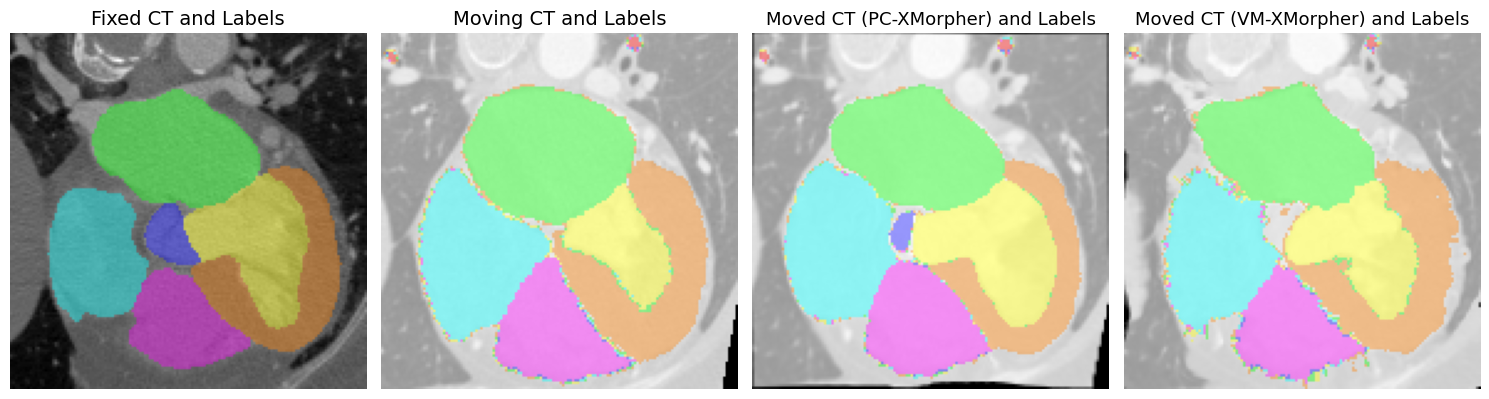

In [ ]:
#xmorpher results (semi and unsup) with labels. needs to be completed
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

def load_nifti(file_path):
    return nib.load(file_path).get_fdata()

def normalize_ct(image, new_min=0, new_max=2048):
    min_value = image.min()
    max_value = image.max()
    return ((image - min_value) / (max_value - min_value)) * (new_max - new_min) + new_min

def set_unique_labels(label):
    label_map = {205: 1, 420: 2, 500: 3, 550: 4, 600: 5, 820: 6, 850: 7}
    for old_value, new_value in label_map.items():
        label = np.where(label == old_value, new_value, label)
    return label

def normalize(image):
    min_val = np.min(image)
    max_val = np.max(image)
    return (image - min_val) / (max_val - min_val) if max_val > min_val else image

def overlay_label(image, label, alpha=0.3):
    # Create a color map for the unique labels
    color_map = {
        1: [1, 0.5, 0],   # Orange
        2: [0, 1, 0],   # Green
        3: [1, 1, 0],   # Yellow 
        4: [0, 1, 1],   # Cyan  
        5: [1, 0, 1],   # Magenta
        6: [0, 0, 1],   # blue
        7: [1, 0, 0]  #  Red
    }

    image = normalize(image)  # Normalize image to [0, 1]
    overlay = np.stack([image] * 3, axis=-1)  # Create a 3-channel grayscale image

    for lbl, color in color_map.items():
        mask = label == lbl
        for c in range(3):  # Apply color for each channel
            overlay[..., c] = np.where(mask, color[c] * alpha + overlay[..., c] * (1 - alpha), overlay[..., c])

    return np.clip(overlay, 0, 1)  # Clip values to ensure they are in [0, 1]

# Load and normalize images

mat_file_path = '/path/to/XMorpher-registration/data/test/8_7.mat'
ct3 = scipy.io.loadmat(mat_file_path)
fix_im = normalize_ct(ct3['fix_img'])
mov_im = normalize_ct(ct3['mov_img'])
fixed_label = set_unique_labels(ct3['fix_lab'])
moving_label = set_unique_labels(ct3['mov_lab'])

# Load and normalize moved CT
moved_ct_path = '/path/to/XMorpher-registration/out/Semi/nifti_out/w_m_to_f/8_7.nii.gz'
moved_ct = normalize_ct(load_nifti(moved_ct_path))

# Load and set unique labels for moved label
moved_label_path = '/path/to/XMorpher-registration/out/Semi/nifti_out/w_label_m_to_f/8_7.nii.gz'
moved_label = set_unique_labels(load_nifti(moved_label_path))



# Load and normalize moved CT
moved_ct_path2 = '/path/to/XMorpher-registration/out/Unsup/nifti_out/w_m_to_f/8_7.nii.gz'
moved_ct2 = normalize_ct(load_nifti(moved_ct_path2))

# Load and set unique labels for moved label
moved_label_path2 = '/path/to/XMorpher-registration/out/Unsup/nifti_out/w_label_m_to_f/8_7.nii.gz'
moved_label2 = set_unique_labels(load_nifti(moved_label_path2))
# Choose a slice to display
slice_num = 50

# Create a figure with three subplots
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

# Display fixed CT with label
ax1.imshow(overlay_label(fix_im[:, :, slice_num].T, fixed_label[:, :, slice_num].T, alpha=0.4))
ax1.set_title('Fixed CT and Labels', fontsize=14)
ax1.axis('off')

# Display moving CT with label
ax2.imshow(overlay_label(mov_im[:, :, slice_num].T, moving_label[:, :, slice_num].T, alpha=0.4))
ax2.set_title('Moving CT and Labels', fontsize=14)
ax2.axis('off')

# Display moved CT with label
ax3.imshow(overlay_label(moved_ct[:, :, slice_num].T, moved_label[:, :, slice_num].T, alpha=0.4))
ax3.set_title('Moved CT (PC-XMorpher) and Labels', fontsize=13)
ax3.axis('off')


# Display moved CT with label
ax4.imshow(overlay_label(moved_ct2[:, :, slice_num].T, moved_label2[:, :, slice_num].T, alpha=0.4))
ax4.set_title('Moved CT (VM-XMorpher) and Labels', fontsize=13)
ax4.axis('off')

plt.tight_layout()
plt.show()
